In [1]:
!conda install -c conda-forge gdcm -y

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
import scipy.ndimage
import gdcm

import glob

from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.morphology import disk, opening, closing
from tqdm import tqdm

from IPython.display import HTML
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from os import listdir, mkdir

## Table of contents


1. [References](#references)
    * [Data Science Bowl 2017 - Preprocessing Tutorial by Guido Zuidhof](#bowl_2017)
    * [Papers](#papers)
2. [Prepare to start](#prepare)
3. [Working with dicom files](#dicom)
    * [Loading CT-scans per patient](#ct_scans)
    * [Transforming to Hounsfield Units](#hunits)
    * [The voxel size](#voxel)
    * [CT-scan slice area and volume - EDA](#scan_eda)
    * [3D-reconstruction of CT-scans](#reconstruction)
    * [Tissue segmentation](#segmentation)
4. [Generating a dataset for preprocessed files](#datagenerator)
    * [Link to public dataset](https://www.kaggle.com/allunia/osic-pulmonary-fibrosis-progression-huscans)
5. [SIIM-FISABIO-RSNA COVID-19 Detection competition](#siim-covid-19)
    * [Peek at the dicom-file](#covid19-dicom-peek)

# References <a class="anchor" id="references"></a>

## Data Science Bowl 2017 - Preprocessing Tutorial by Guido Zuidhof <a class="anchor" id="bowl_2017"></a>

Once upon a time there was a data science bowl about lung cancer detection that had a fantastic preprocessing tutorial: https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial ;-)

* My notebook heavily uses the concepts and code snippets of this notebook by Guido Zuidhof. 
* With my work I like to bring back his ideas to following pulmonary competitions based on CT-scans and I like to add a few more explanations while writing it. 
* Furthermore I hope that I can help to generate a dataset in the end that contains the preprocessed data to feed into your models.

Have fun! :-)

## Papers <a class="anchor" id="papers"></a>

To understand what and why we are doing these concepts here, I started to read a few papers:

* [Intrinsic dependencies of CT radiomic features on voxel size and number of gray levels](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5462462/)

# Prepare to start <a class="anchor" id="prepare"></a>

In [3]:
listdir("../input/")

['siim-covid19-detection',
 'osic-pulmonary-fibrosis-progression',
 'rsna-str-pulmonary-embolism-detection']

In [4]:
#basepath = "../input/osic-pulmonary-fibrosis-progression/"

# or if you were taking part in RSNA pulmonary embolism detection:
basepath = "../input/rsna-str-pulmonary-embolism-detection/"

Let's load the csv-files:

In [5]:
train = pd.read_csv(basepath + "train.csv")
test = pd.read_csv(basepath + "test.csv")

In [6]:
train.shape

(1790594, 17)

In [7]:
train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [8]:
if basepath == "../input/osic-pulmonary-fibrosis-progression/":
    train["dcm_path"] = basepath + "train/" + train.Patient + "/"
elif basepath == "../input/rsna-str-pulmonary-embolism-detection/":
    train["dcm_path"] = basepath + "train/" + train.StudyInstanceUID + "/" + train.SeriesInstanceUID 
else:
    train["dcm_path"] = basepath + "train/" + train.StudyInstanceUID + "/" 

# Working with dicom files <a class="anchor" id="dicom"></a>

## Loading CT-scans per patient <a class="anchor" id="ct_scans"></a>

* To load the full 3D-scan we need to order the single dicom files/slices by the ImagePosition: 

In [9]:
def load_scans(dcm_path):
    if basepath == "../input/rsna-str-pulmonary-embolism-detection/":
        # We sort by ImagePositionPatient (z-coordinate) or by SliceLocation
        slices = [pydicom.dcmread(dcm_path + "/" + file) for file in listdir(dcm_path)]
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    else: #basepath == "../input/osic-pulmonary-fibrosis-progression/":    
        # This competition shows missing values in ImagePosition,
        # this is why we are sorting by filename number
        files = listdir(dcm_path)
        file_nums = [np.int(file.split(".")[0]) for file in files]
        sorted_file_nums = np.sort(file_nums)[::-1]
        slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
    return slices

In [10]:
example = train.dcm_path.values[0]
scans = load_scans(example)

In [11]:
example

'../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b'

Let's take a look at the first dicom file of our example patient:

In [12]:
scans[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 172
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.405991.10080
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI DUAL', 'STD', 'SNRG', 'DET_AB']
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: baedb900c69c
(0008, 0060) Modality                            CS: 'CT'
(0018, 0

If you haven't worked with dicom so far, I can recommend this video. If you like to speed up, start at 7 min:

In [13]:
HTML('<iframe width="600" height="400" src="https://www.youtube.com/embed/KZld-5W99cI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### Adding further information

1. The CT-scan captures information about the radiodensity of an object or tissue exposed to x-rays. A transversal slice of a scan is reconstructed after taking measurements from several different directions.
2. We need to transform to Hounsfield units as the spectral composition of the x-rays depends on the measurement settings like acquisition parameters and tube voltage. By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable.
3. A ct-scanner yields roughly 4000 grey values that can't be captured by our eyes. This is why windowing is performed. This way the image is displayed in a HU range that suites most to the region of interest. 

## Transforming to Hounsfield Units <a class="anchor" id="hunits"></a>

Before starting, let's plot the pixelarray distribution of some dicom files to get an impression of the raw data:

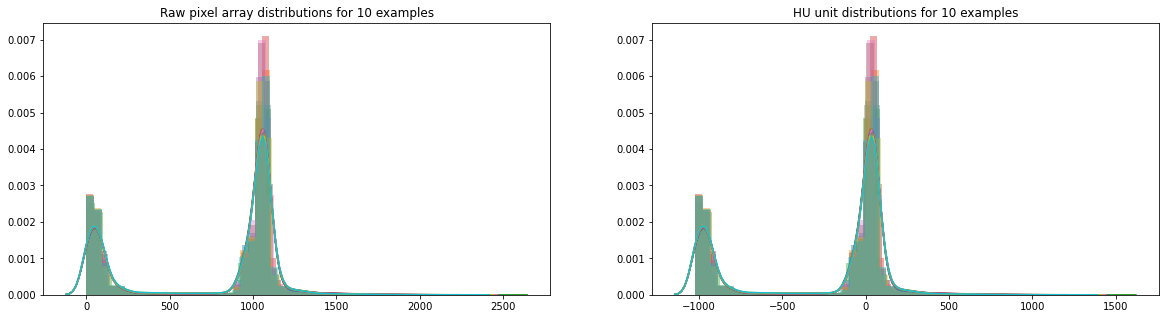

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
for n in range(10):
    image = scans[n].pixel_array.flatten()
    rescaled_image = image * scans[n].RescaleSlope + scans[n].RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

For some examples we can see that there are raw values at -2000. They correspond to images with a circular boundary within the image. The "outside" of this circle value is often set to -2000 (or in other competitions I found also -3000) by default.

In [15]:
def set_outside_scanner_to_air(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

In [16]:
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

In [17]:
hu_scans = transform_to_hu(scans)

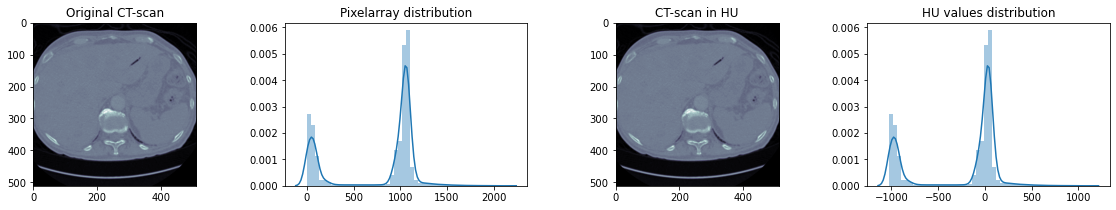

In [18]:
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax[0].set_title("Original CT-scan")
ax[0].imshow(scans[0].pixel_array, cmap="bone")
ax[1].set_title("Pixelarray distribution");
sns.distplot(scans[0].pixel_array.flatten(), ax=ax[1]);

ax[2].set_title("CT-scan in HU")
ax[2].imshow(hu_scans[0], cmap="bone")
ax[3].set_title("HU values distribution");
sns.distplot(hu_scans[0].flatten(), ax=ax[3]);

for m in [0,2]:
    ax[m].grid(False)

Ok great. Now all raw values per slice are scaled to H-units.

## The voxel size <a class="anchor" id="voxel"></a>

The voxel stands for the 3D-pixel that is given in a CT-scan. As far as I know it is spanned by the 2d-plane of the pixelspacing attribute in x- and y-direction and the slice thickness in z-direction.

### Pixelspacing

* The pixelspacing attribute you can find in the dicom files is an important one. It tells us how much physical distance is covered by one pixel. You can see that there are only 2 values that describe the x- and y-direction in the plane of a transversal slice. 
* For one patient this pixelspacing is usually the same for all slices.
* But between patients the pixelspacing can differ due to personal or institutional preferences of doctors and the clinic and it also depends on the scanner type. Consequently if you compare two images in the size of the lungs it does not automatically mean that the bigger one is really larger in the physical size of the organ!

Let's explore the distributions of the patients pixelspacing widths and heights of this competition:

In [19]:
N = 1000

Just to speed up the computation, I have selected N patients to consider. Use N = train.shape[0] to do this for all patients in the dataset:

In [20]:
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
patient_id = []
patient_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []

if basepath == "../input/osic-pulmonary-fibrosis-progression/":
    patients = train.Patient.unique()[0:N]
else:
    patients = train.SeriesInstanceUID.unique()[0:N]

for patient in patients:
    patient_id.append(patient)
    if basepath == "../input/osic-pulmonary-fibrosis-progression/":
        path = train[train.Patient == patient].dcm_path.values[0]
    else:
        path = train[train.SeriesInstanceUID == patient].dcm_path.values[0]
    example_dcm = listdir(path)[0]
    patient_pth.append(path)
    dataset = pydicom.dcmread(path + "/" + example_dcm)
    
    window_widths.append(get_window_value(dataset.WindowWidth))
    window_levels.append(get_window_value(dataset.WindowCenter))
    
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    
    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])
    
scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "patient_pth"] = patient_pth
scan_properties.loc[:, "window_width"] = window_widths
scan_properties.loc[:, "window_level"] = window_levels
scan_properties.head()

,patient,rows,columns,area,pixelspacing_r,pixelspacing_c,pixelspacing_area,slice_thickness,patient_pth,window_width,window_level
0,2bfbb7fd2e8b,512,512,262144,0.523438,0.523438,0.273987,2.0,../input/rsna-str-pulmonary-embolism-detection...,400,40
1,2805267980e7,512,512,262144,0.580078,0.580078,0.336491,2.0,../input/rsna-str-pulmonary-embolism-detection...,350,50
2,bac7becd2970,512,512,262144,0.615234,0.615234,0.378513,2.0,../input/rsna-str-pulmonary-embolism-detection...,400,40
3,7d17c72fd0ce,512,512,262144,0.648438,0.648438,0.420471,3.0,../input/rsna-str-pulmonary-embolism-detection...,400,40
4,275497911f02,512,512,262144,0.648438,0.648438,0.420471,3.0,../input/rsna-str-pulmonary-embolism-detection...,400,40


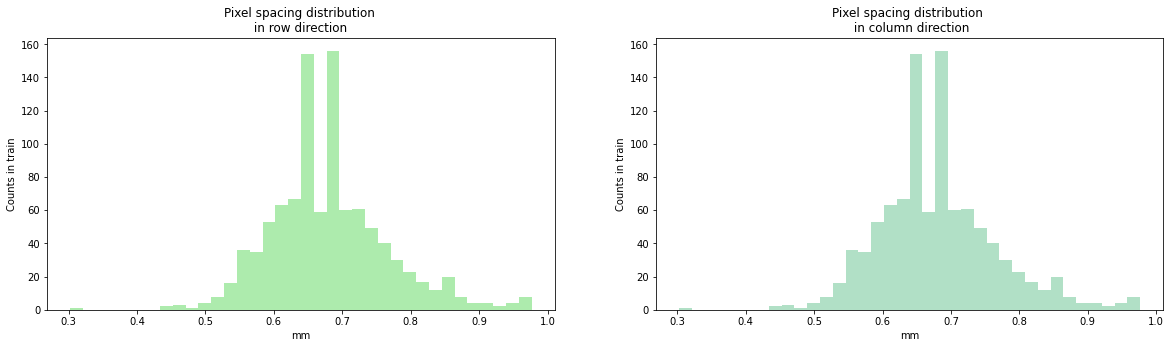

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_r, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("mm")
sns.distplot(pixelspacing_c, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("mm");

We can see that the values really vary a lot from patient to patient! As they are given in mm and ct-scans usually cover 512 row and column values... **oh wait! we need to check this!** ... we can compute the minimum and maximum distance that is covered by the images:

### Slice thickness and pixel area

The slice thickness tells us how much distance is covered in Z-direction by one slice. Let's plot the distribution of it as well. Furthermore the pixel_array of raw values covers a specific area given by row and column values. Let's take a look at it as well: 

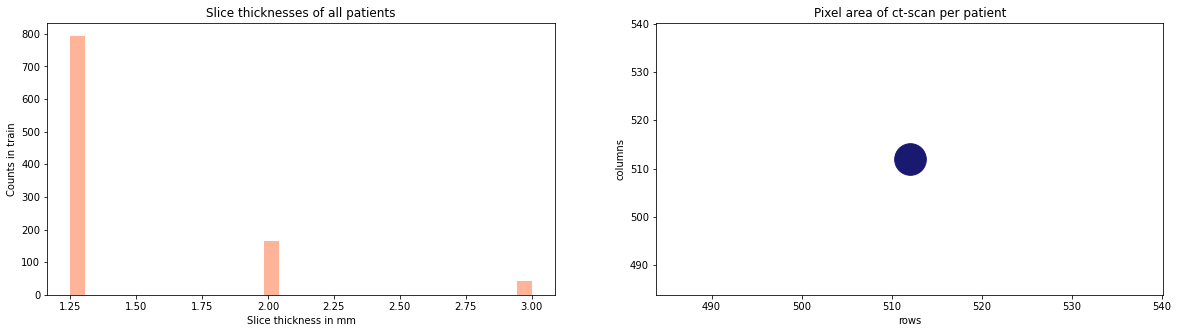

In [22]:
counts = scan_properties.groupby(["rows", "columns"]).size()
counts = counts.unstack()
counts.fillna(0, inplace=True)


fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(slice_thicknesses, color="orangered", kde=False, ax=ax[0])
ax[0].set_title("Slice thicknesses of all patients");
ax[0].set_xlabel("Slice thickness in mm")
ax[0].set_ylabel("Counts in train");

for n in counts.index.values:
    for m in counts.columns.values:
        ax[1].scatter(n, m, s=counts.loc[n,m], c="midnightblue")
ax[1].set_xlabel("rows")
ax[1].set_ylabel("columns")
ax[1].set_title("Pixel area of ct-scan per patient");

* Very thin slices allow more details to be shown. On the other hand thick slices contain less noise but are more prone to artifacts. Hmm... I'm very excited to see some examples here as well. 
* Even though it is common to have 512x512 pixel size areas, we can see that this is not always true!! We can find a lot of exceptions and even one or a few very large pixel areas (1300x1300)!!! (OSIC)
* Proper preprocessing of these scans might be very important... we have to check it.

## Physical area & slice volume covered by a single ct-scan

Now, we know some important quantities to compute the physical distance covered by a ct-scan!

In [23]:
scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

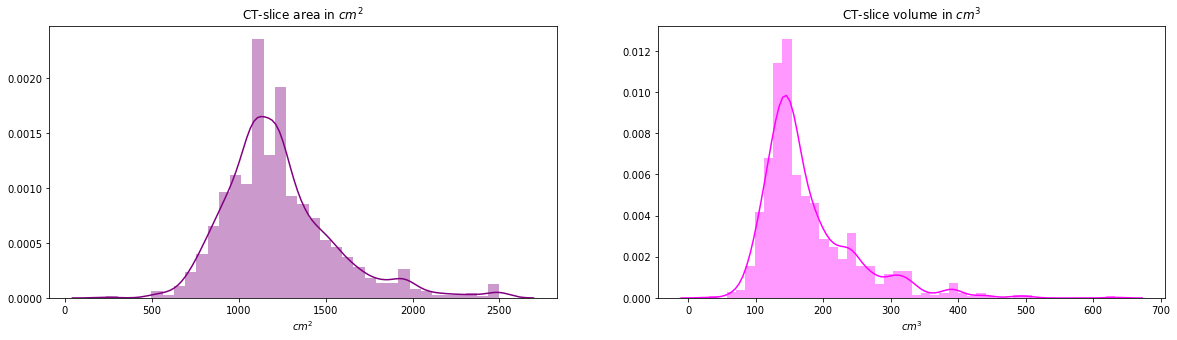

In [24]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(scan_properties.area_cm2, ax=ax[0], color="purple")
sns.distplot(scan_properties.slice_volume_cm3, ax=ax[1], color="magenta")
ax[0].set_title("CT-slice area in $cm^{2}$")
ax[1].set_title("CT-slice volume in $cm^{3}$")
ax[0].set_xlabel("$cm^{2}$")
ax[1].set_xlabel("$cm^{3}$");

Ohoh! We have some images with extreme large sliche areas and volumes! I think it's time to do some EDA regarding these features! 

## CT-scan slice area and volume - EDA <a class="anchor" id="scan_eda"></a>

### Smallest and larges CT-slice area

In [25]:
max_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.min()].patient_pth.values[0]

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)

background_water_hu_scans = max_hu_scans.copy()

In [26]:
def set_manual_window(hu_image, custom_center, custom_width):
    w_image = hu_image.copy()
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    w_image[w_image < min_value] = min_value
    w_image[w_image > max_value] = max_value
    return w_image

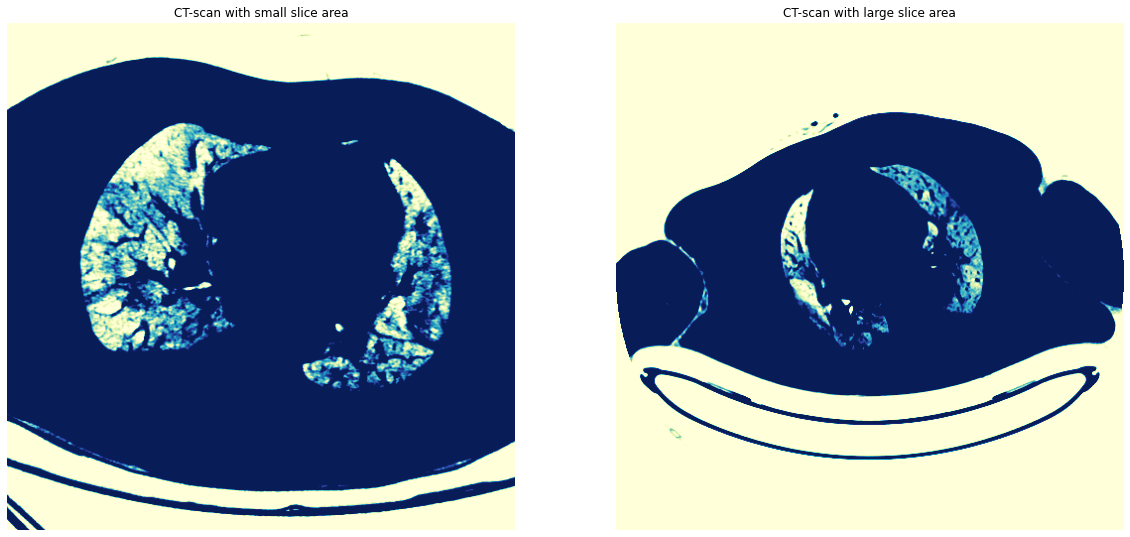

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[np.int(len(min_hu_scans)/2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[np.int(len(max_hu_scans)/2)], -700, 255), cmap="YlGnBu");
ax[0].set_title("CT-scan with small slice area")
ax[1].set_title("CT-scan with large slice area");
for n in range(2):
    ax[n].axis("off")

### Insights

* Taking a look at one slice of a scan with smallest and largest slice area, we can see that the large one has a lot of useless region covered. We could crop it.
* Strange... in the second image with the large area the outside region of the scanner tube is not set to the value of air but rather to some value in the middle of the range -1000 to 1000.

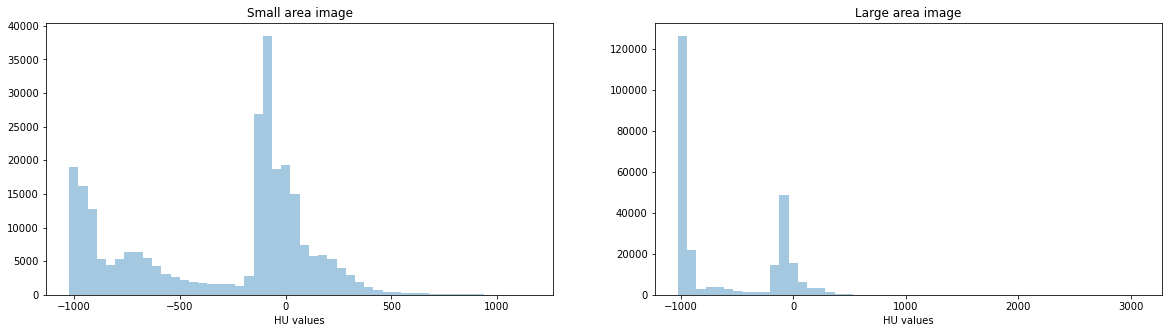

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(max_hu_scans[np.int(len(max_hu_scans)/2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large area image")
sns.distplot(min_hu_scans[np.int(len(min_hu_scans)/2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small area image")
ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values");

* For the OSIC example we can find: Ihh... it was set to water by default in the large image... why?! That's bad! We need to find some strategy to deal with this problem. It's not good that we sometimes have "water"-like outside regions and sometimes "air"-like regions.

### Smallest and largest CT-slice volume

In [29]:
max_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.min()].patient_pth.values[0]

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)

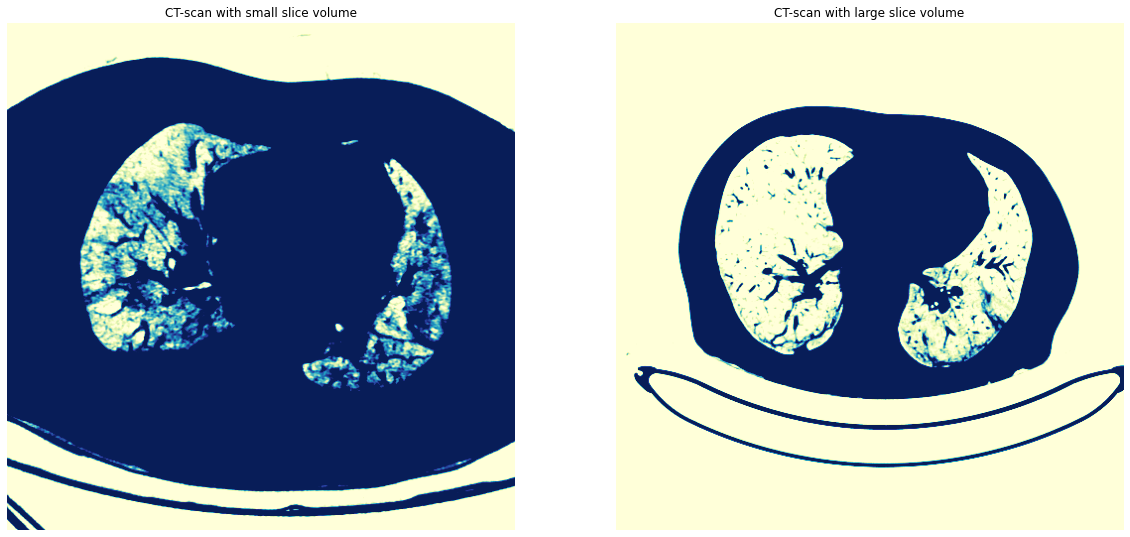

In [30]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[np.int(len(min_hu_scans)/2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[np.int(len(max_hu_scans)/2)], -700, 255), cmap="YlGnBu");
ax[0].set_title("CT-scan with small slice volume")
ax[1].set_title("CT-scan with large slice volume");
for n in range(2):
    ax[n].axis("off")

Hmm I can't see a great difference. Perhaps the one with the large slice volume looks a bit more blurred. But as above there is an outside-scanner region that was set to the walue of water (HU value of 0) instead of air.

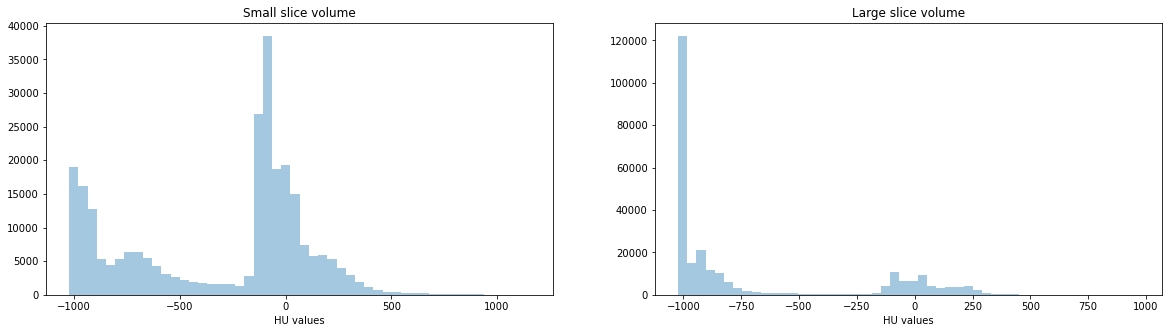

In [31]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(max_hu_scans[np.int(len(max_hu_scans)/2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large slice volume")
sns.distplot(min_hu_scans[np.int(len(min_hu_scans)/2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small slice volume")
ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values");

## 3D-reconstruction of CT-scans <a class="anchor" id="reconstruction"></a>

The plot_3d works well in the Data Science Bowl 2017 but in our case the results are not so well. It depends on the threshold but so far I don't know why our reconstructions often look blurred or show tube regions as well. :-(

In [32]:
def plot_3d(image, threshold=700, color="navy"):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,_,_ = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

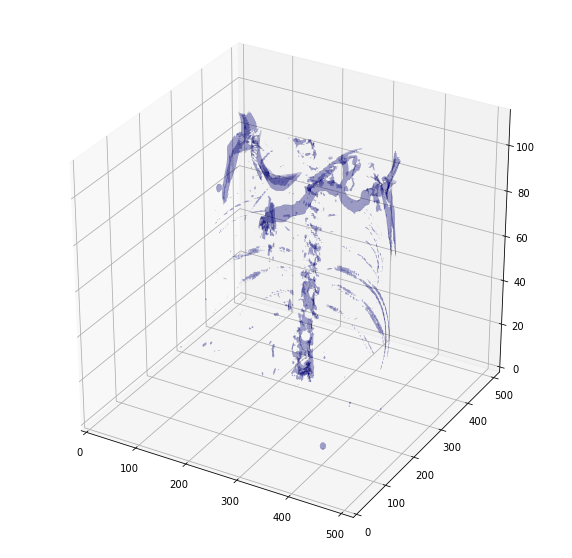

In [33]:
plot_3d(max_hu_scans)

You can see that this looks quite different to this one:

In [34]:
old_distribution = max_hu_scans.flatten()

In [35]:
example = train.dcm_path.values[0]
scans = load_scans(example)
hu_scans = transform_to_hu(scans)

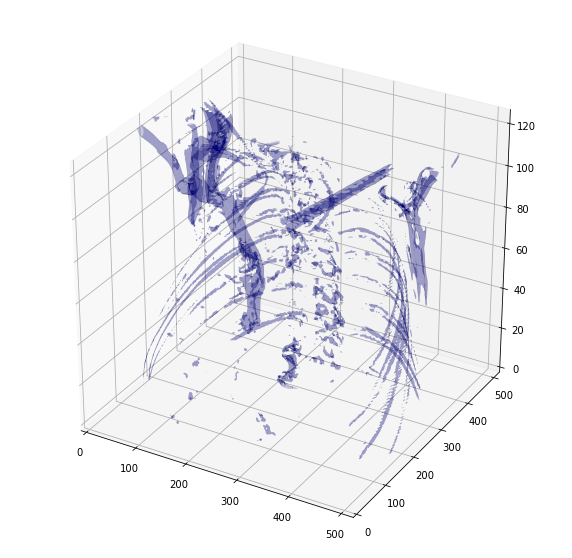

In [36]:
plot_3d(hu_scans)

Compare to above this one looks far better. Let's plot the distributions. Perhaps we can understand what's going wrong by taking a look at them:

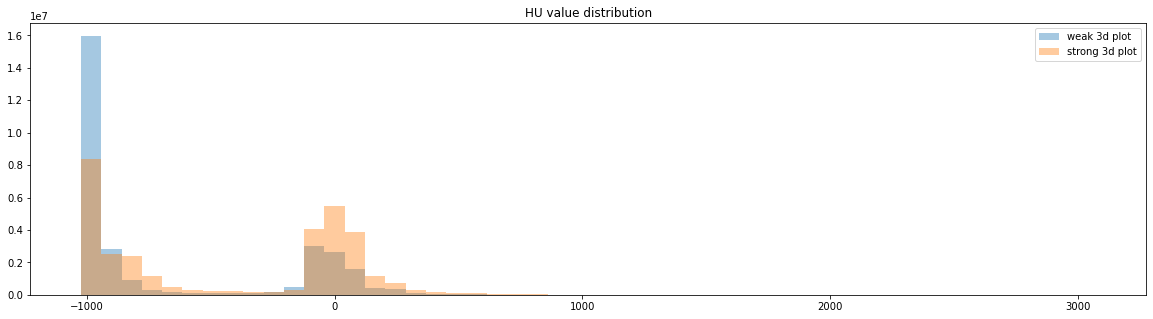

In [37]:
plt.figure(figsize=(20,5))
sns.distplot(old_distribution, label="weak 3d plot", kde=False)
sns.distplot(hu_scans.flatten(), label="strong 3d plot", kde=False)
plt.title("HU value distribution")
plt.legend();

Hmm

In [38]:
print(len(max_hu_scans), len(hu_scans))

113 124


I think we need to understand the marching_cubes_lewiner algorithm to understand why the plot sometimes works nice and sometimes not. But I think this is not really important for the competition itself. At the moment I don't like to spend more time on that topic. Perhaps it's more important to keep in mind that the overall distributions can be different.

## Resampling the voxel size

I'm not sure if it's really important to do this resampling, because we can already do a lot with augmentations. We can resize, crop, blur and shift intensities. Also the background-problem with outside scanner regions set to water HU-values can be solved. For this reason I don't like to do the resampling. ;-) Perhaps you like to do it. For this purpose I leave the code from Guidos notebook: 

In [39]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    
    # recompute the resize factor and spacing such that we match the rounded new shape above
    rounded_resize_factor = new_shape / image.shape
    rounded_new_spacing = spacing / rounded_resize_factor
    
    # zoom with resize factor
    image = scipy.ndimage.interpolation.zoom(image, rounded_resize_factor, mode='nearest')
    
    return image, rounded_new_spacing

In [40]:
img_resampled, spacing = resample(max_hu_scans, scans, [1,1,1])
print("Shape before resampling\t", max_hu_scans.shape)
print("Shape after resampling\t", img_resampled.shape)

Shape before resampling	 (113, 512, 512)
Shape after resampling	 (226, 268, 268)


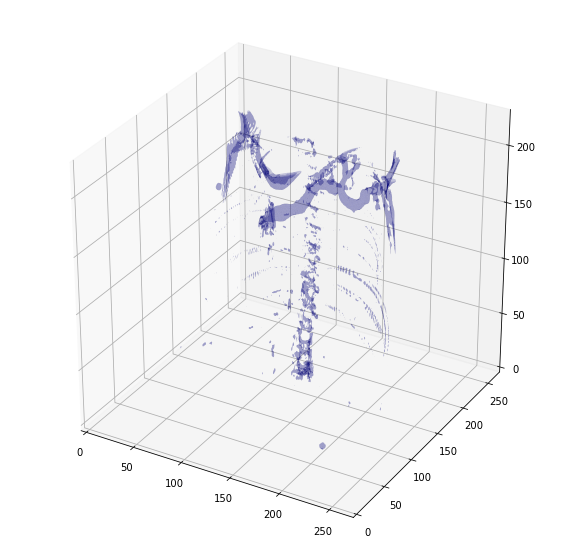

In [41]:
plot_3d(img_resampled)

Looks the same as the max_hu_scans above!

## Tissue segmentation <a class="anchor" id="segmentation"></a>

I built this solution upon Guidos that did not work well in this competition. Here is code I won't use but I kept it to show by example why I found it not helpful:

In [42]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def fill_lungs(binary_image):
    image = binary_image.copy()
    # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(image):
        axial_slice = axial_slice - 1
        labeling = measure.label(axial_slice)
        l_max = largest_label_volume(labeling, bg=0)

        if l_max is not None: #This slice contains some lung
            image[i][labeling != l_max] = 1
    return image


This is now the segmentation function I am using:

In [43]:
def segment_lung_mask(image):
    segmented = np.zeros(image.shape)   
    
    for n in range(image.shape[0]):
        binary_image = np.array(image[n] > -320, dtype=np.int8)+1
        labels = measure.label(binary_image)
        
        bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]])
        for bad_label in bad_labels:
            binary_image[labels == bad_label] = 2
    
        #We have a lot of remaining small signals outside of the lungs that need to be removed. 
        #In our competition closing is superior to fill_lungs 
        selem = disk(2)
        binary_image = opening(binary_image, selem)
    
        binary_image -= 1 #Make the image actual binary
        binary_image = 1-binary_image # Invert it, lungs are now 1
        
        segmented[n] = binary_image.copy() * image[n]
    
    return segmented

### Understanding the segmentation step by step:

First of all we are separating between "potentially lung" with values smaller or equal to 320. Why 320? I just kept the value of Guidos old notebook. Try out your own values if you like. ;-) Before you do so, you make like to take a look at the hu_value distribution again:

Text(0, 0.5, 'count')

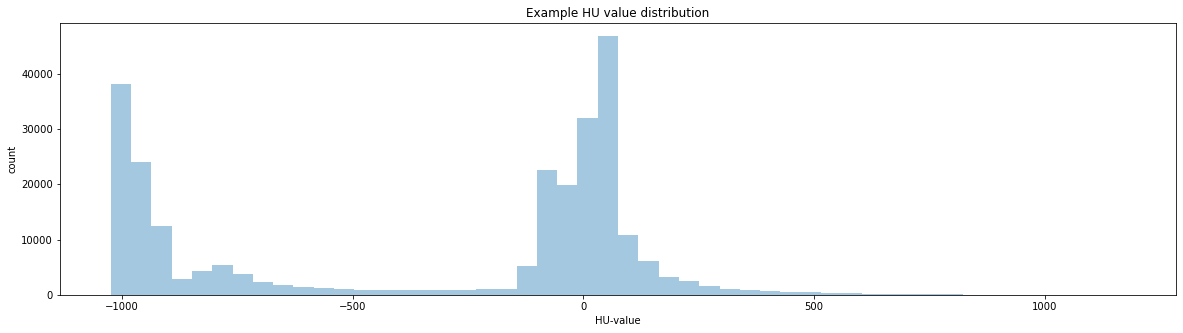

In [44]:
plt.figure(figsize=(20,5))
sns.distplot(hu_scans[20], kde=False)
plt.title("Example HU value distribution");
plt.xlabel("HU-value")
plt.ylabel("count")

With -320 we are separating between lungs (-700) /air (-1000) and tissue with values close to water (0).

In [45]:
binary_image = np.array((hu_scans[20]>-320), dtype=np.int8) + 1
np.unique(binary_image)

array([1, 2], dtype=int8)

Lungs have values of 1 as well as air backgrounds. In contrast water-like default backgrounds and many other organic tissues or fluids have values of 2. As we only like to segment the lungs, we need to remove the background. In the case of air and air-like default values we need to do set their values manually to 2. We can do so by labelling connected regions in the binary image and extracting the labels of each region that corresponds to the corners or edges of the 2D image slice:

In [46]:
labels = measure.label(binary_image)

bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]])

Now we can set all labelled regions of the binary image that correspond to these corner-labels to the "not-lung"-value 2:

In [47]:
binary_image_2 = binary_image.copy()
for bad_label in bad_labels:
    binary_image_2[labels == bad_label] = 2

The result of these steps looks as follows:

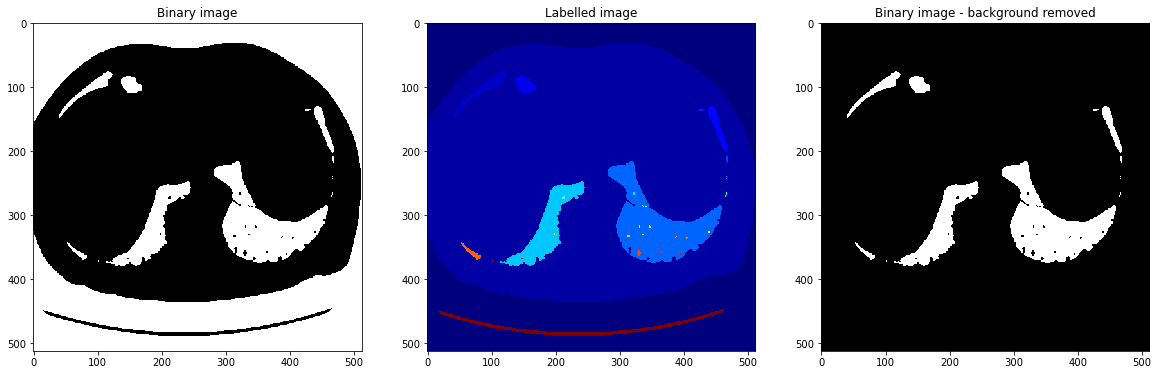

In [48]:
fig, ax = plt.subplots(1,3,figsize=(20,7))
ax[0].imshow(binary_image, cmap="binary", interpolation='nearest')
ax[1].imshow(labels, cmap="jet", interpolation='nearest')
ax[2].imshow(binary_image_2, cmap="binary", interpolation='nearest')

ax[0].set_title("Binary image")
ax[1].set_title("Labelled image");
ax[2].set_title("Binary image - background removed");

### Insights

1. The first image shows the raw binary. In this case we find air as background and we need to set it to the "not-lung" value of 2.
2. For this purpose we label all connected regions in the binary image. There are many different labelled regions but the only ones we are interested in are the 4 corner regions at (0,0), (0,500), (500,0) and (500,500).
3. Knowing the related labels help us to manually set the background to the value 2 (black).
4. In the end we can see that the lungs are white (1) but we still find a lot of remaining signals that correspond to body tissue that we still need to remove.

To remove the signals we can use morphological closing. If you like play with the disk value. It must be large enough to cancel the body signals but small enough to keep enough details inside the lungs:

In [49]:
selem = disk(2)
closed_binary_2 = closing(binary_image_2, selem)

closed_binary_2 -= 1 #Make the image actual binary
closed_binary_2 = 1-closed_binary_2 # Invert it, lungs are now 1

Let's compare with Guidos fill-lungs method:

In [50]:
filled_lungs_binary = fill_lungs(binary_image_2)

And with his air-pocket removal:

In [51]:
air_pocket_binary = closed_binary_2.copy()
# Remove other air pockets insided body
labels_2 = measure.label(air_pocket_binary, background=0)
l_max = largest_label_volume(labels_2, bg=0)
if l_max is not None: # There are air pockets
    air_pocket_binary[labels_2 != l_max] = 0

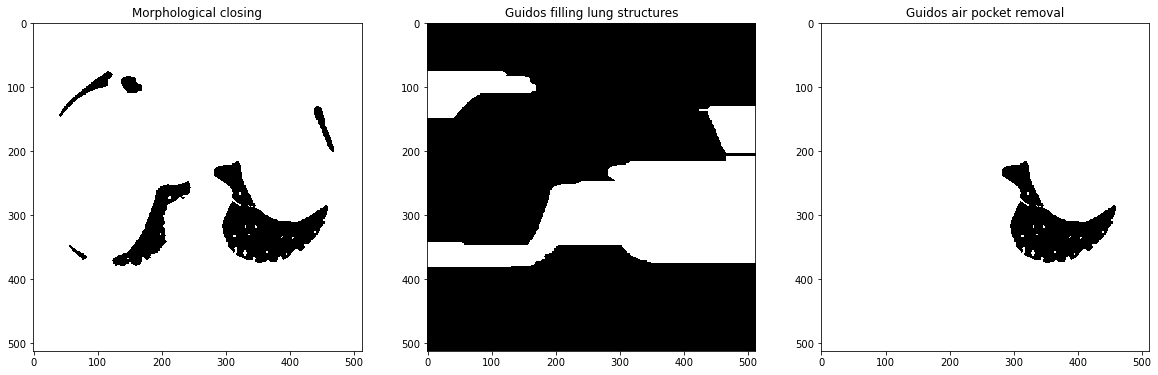

In [52]:
fig, ax = plt.subplots(1,3,figsize=(20,7))

ax[0].imshow(closed_binary_2, cmap="binary", interpolation='nearest')
ax[1].imshow(filled_lungs_binary, cmap="binary", interpolation='nearest')
ax[2].imshow(air_pocket_binary, cmap="binary", interpolation='nearest')


ax[0].set_title("Morphological closing");
ax[1].set_title("Guidos filling lung structures");
ax[2].set_title("Guidos air pocket removal");

### Insights

* The morphological closing worked better than Guidos method. But we are often missing a lot of information inside the lungs just to remove these body signals. There is definitely room for improvements! ;-)
* In contrast the fill-lung method has troubles with the remaining singals of the body and yields not what we like to obtain.
* Furthermore the air-pocket removal does also not work well.

Probably I'm having some kind of bug. Can't imagine that Guidos methods didn't work at all?! For this reason I just stayed with the simplest solution of morphological closing.

### Final solution

And here is how it looks like if we mask the original image with the segmented binary lungs in our 2D example:

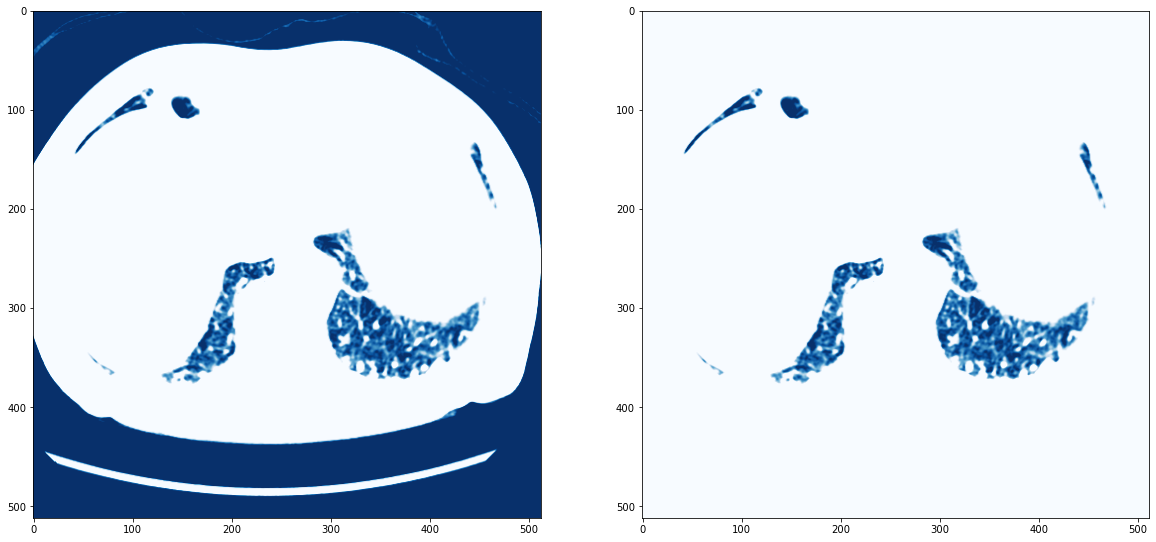

In [53]:
segmented = segment_lung_mask(np.array([hu_scans[20]]))

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(hu_scans[20], -700, 255), cmap="Blues_r")
ax[1].imshow(set_manual_window(segmented[0], -700, 255), cmap="Blues_r");

And we can also check how it looks in the 3D case:

In [54]:
segmented_lungs = segment_lung_mask(hu_scans)

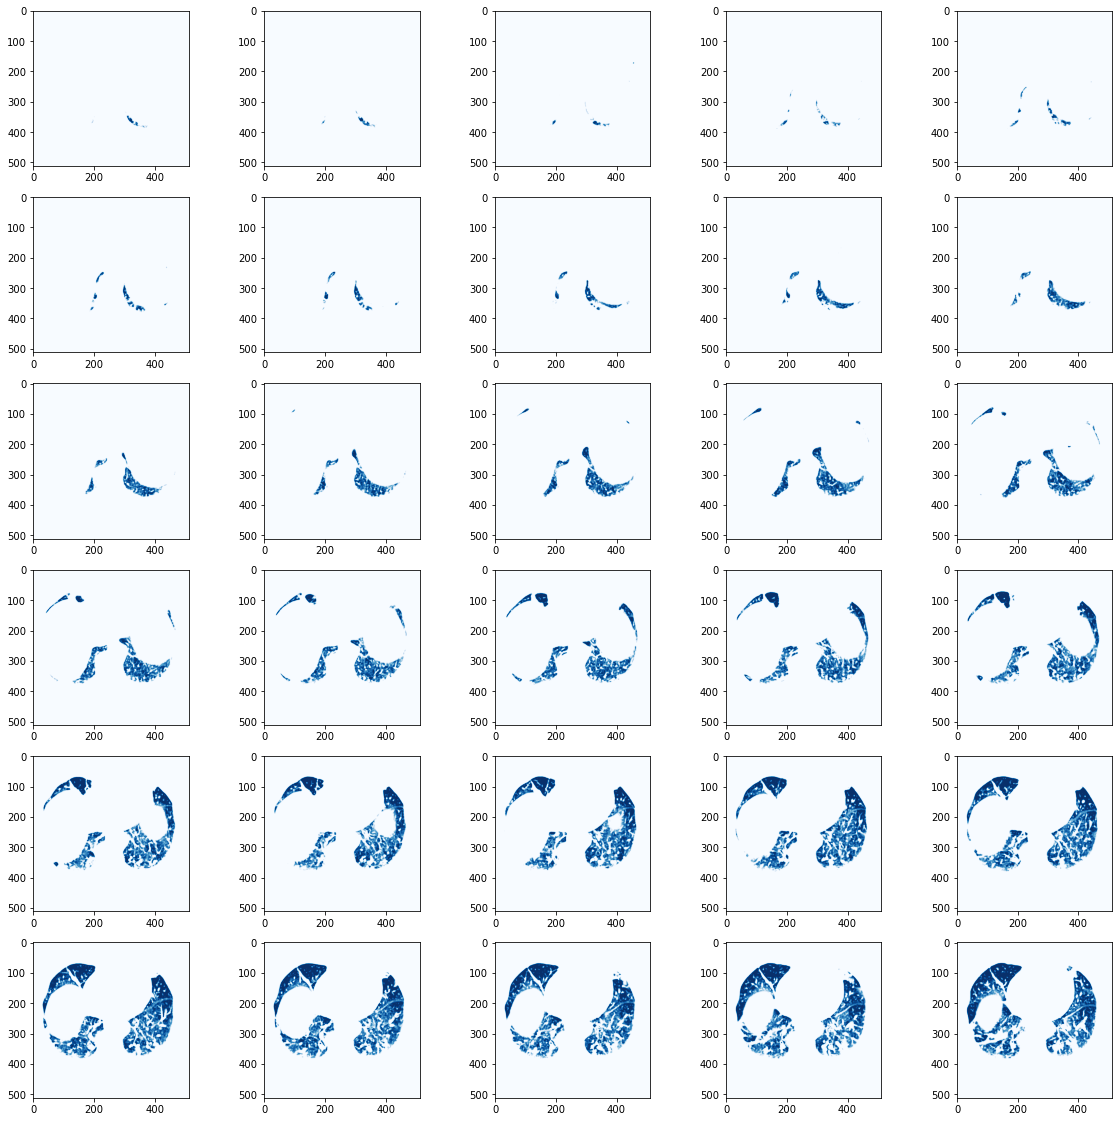

In [55]:
fig, ax = plt.subplots(6,5, figsize=(20,20))
for n in range(6):
    for m in range(5):
        ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], -700, 255), cmap="Blues_r")

Interesting that we still have some signals outside of the lungs:

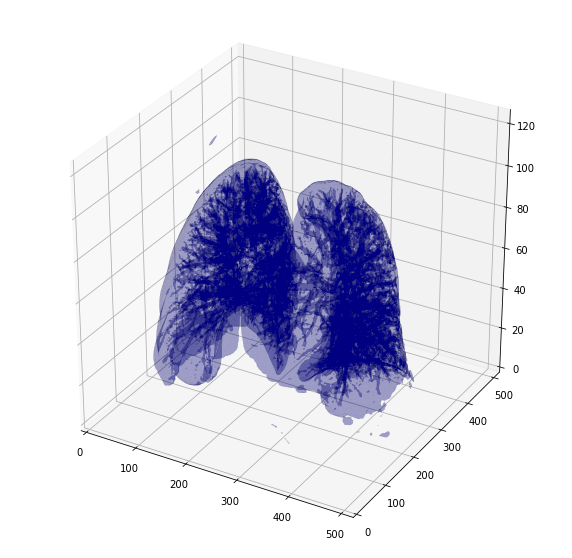

In [56]:
plot_3d(segmented_lungs, threshold=-600)

If you like try to improve the segmentation and play with your own ideas and concepts! :-) I like to create two datasets - one with segmentation already done and one without. So you can decide on your own if you like to build a custom augmentation that performs the segmentation on the fly when loading your batches.

# Generating a dataset for preprocessed files <a class="anchor" id="datagenerator"></a>


## Dealing with different image-scan sizes <a class="anchor" id="image_sizes"></a>

To generate the data, we should take a look again at the different images sizes: For OSIC we have two major size groups and some minor outliers. For example we could manually resize or crop the outliers and find a strategy for the two major groups. Let's take a look at the sizes again:

In [57]:
image_sizes = scan_properties.groupby(["rows", "columns"]).size().sort_values(ascending=False)
image_sizes

rows  columns
512   512        1000
dtype: int64

For OSIC it's interesting that we have two different kind of patterns. In the RSNA competition all training images are of shape 512, 512. So you don't need to explore the image sizes further. But perhaps it's still useful to browse through the images to gain ideas for good augmentations.

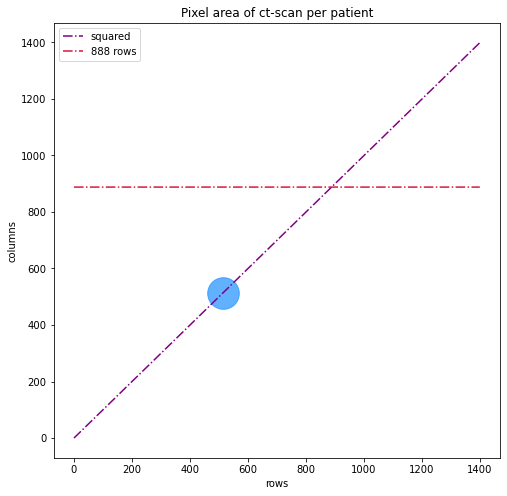

In [58]:
plt.figure(figsize=(8,8))
for n in counts.index.values:
    for m in counts.columns.values:
        plt.scatter(n, m, s=counts.loc[n,m], c="dodgerblue", alpha=0.7)
plt.xlabel("rows")
plt.ylabel("columns")
plt.title("Pixel area of ct-scan per patient");
plt.plot(np.arange(0,1400), '-.', c="purple", label="squared")
plt.plot(888 * np.ones(1400), '-.', c="crimson", label="888 rows");
plt.legend();

Such kind of obvious patterns are always worth to take a look at. Perhaps we can find some kind of rule that allows us to create a good resizing strategy. Here is a small observer that allows you to browse through the files by just running the code cell again:

In [59]:
class ImageObserver:
    
    def __init__(self, scan_properties, batch_size):
        self.scan_properties = scan_properties
        self.batch_size = batch_size
    
    def select_group(self, group=(512,512)):
        self.group = group
        self.name = "rows {}, columns {}".format(group[0], group[1])
        self.batch_shape = (self.batch_size, group[0], group[1])
        self.selection = self.scan_properties[
            (self.scan_properties["rows"]==group[0]) & (self.scan_properties["columns"]==group[1])
        ].copy()
        self.patient_pths = self.selection.patient_pth.unique()
    
    
    def get_loader(self):
        
        idx=0
        images = np.zeros(self.batch_shape)
        
        for path in self.patient_pths:
            
            scans = load_scans(path)
            hu_scans = transform_to_hu(scans)
            images[idx,:,:] = hu_scans[0]
            
            idx += 1
            if idx == self.batch_shape[0]:
                yield images
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield images

In [60]:
my_choice = image_sizes.index.values[0]
print(my_choice)
to_display = 4

(512, 512)


In [61]:
observer = ImageObserver(scan_properties, to_display)
observer.select_group(my_choice)
observer_iterator = observer.get_loader()

Just run the following cell again, to observe the next batch of images:

In [62]:
images = next(observer_iterator)

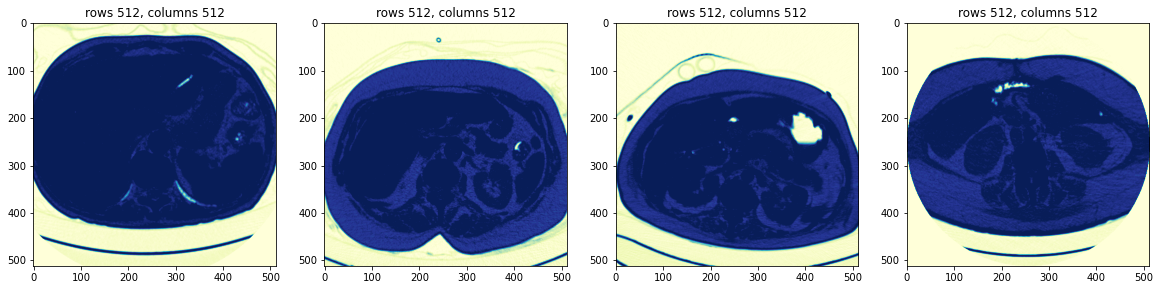

In [63]:
fig, ax = plt.subplots(1,to_display,figsize=(20,5))


for m in range(to_display):
    image = images[m]
    ax[m].imshow(set_manual_window(image, -500, 1000), cmap="YlGnBu")
    ax[m].set_title(observer.name)

### Insights

Browse through the different groups and you will find out for OSIC that...

* The large squared image sizes often show resolutions higher than with 512 rows and 512 columns. Here resizing to the two major groups (512, 512) or (768, 768) makes sense.
* In the non-squared cases a center crops should work best as they only have more background values but still belong to the major groups in the inside-scanner-region.

## Generating non-segmented, original raw image data <a class="anchor" id="non_segmented_original"></a>

https://www.kaggle.com/allunia/osic-pulmonary-fibrosis-progression-huscans

The least we can do is to resize and crop all those images that don't have a shape of (512,512) and to transform their values to Hounsfield units. Furthermore we can create smaller images by resizing to a desired shape. As far as I know this is not that easy as it sounds as we won't use common Image dtypes but rather original HU values without converting them. Most image preprocessing packages I found can't easily deal with numpy arrays. For this reason I used a workaround:

* I changed the dytpe of my hu-transformed numpy-array scans to Int32
* This way I can pass them to PILs Image class using fromarray with mode="I"
* Then I can use the resize and crop method of this package
* After that the array turns back to Int16 as I like to reduce memory cost

Hmm... still feels not good and I'm also a bit confused. You can see that dicom can also be covered with most common Image preprocessing packages this way:

* https://www.kaggle.com/onealbao/dicom-to-jpeg-conversion-kernel

I still need to read about converting dicom or "how to loose or not loose information"! ;-)

In [64]:
scan_properties.shape

(1000, 15)

176 different patients in train!

In [65]:
scan_properties.head(1)

,patient,rows,columns,area,pixelspacing_r,pixelspacing_c,pixelspacing_area,slice_thickness,patient_pth,window_width,window_level,r_distance,c_distance,area_cm2,slice_volume_cm3
0,2bfbb7fd2e8b,512,512,262144,0.523438,0.523438,0.273987,2.0,../input/rsna-str-pulmonary-embolism-detection...,400,40,268.0,268.0,718.24,143.648


In [66]:
def resize_scan(scan, new_shape):
    # read slice as 32 bit signed integers
    img = Image.fromarray(scan, mode="I")
    # do the resizing
    img = img.resize(new_shape, resample=Image.LANCZOS)
    # convert back to 16 bit integers
    resized_scan = np.array(img, dtype=np.int16)
    return resized_scan

In [67]:
def crop_scan(scan):
    img = Image.fromarray(scan, mode="I")
    
    left = (scan.shape[0]-512)/2
    right = (scan.shape[0]+512)/2
    top = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2

    img = img.crop((left, top, right, bottom))
    # convert back to 16 bit integers
    cropped_scan = np.array(img, dtype=np.int16)
    return cropped_scan

In [68]:
def crop_and_resize(scan, new_shape):
    img = Image.fromarray(scan, mode="I")
    
    left = (scan.shape[0]-512)/2
    right = (scan.shape[0]+512)/2
    top = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2
    
    img = img.crop((left, top, right, bottom))
    img = img.resize(new_shape, resample=Image.LANCZOS)
    
    cropped_resized_scan = np.array(img, dtype=np.int16)
    return cropped_resized_scan

Have to rework this part for RSNA!

In [69]:
def preprocess_to_hu_scans(scan_properties, my_shape, output_dir):
    
    for i, patient in enumerate(tqdm(scan_properties.patient.values)):
        pth = scan_properties.loc[scan_properties.patient==patient].patient_pth.values[0]
        scans = load_scans(pth)
        hu_scans = transform_to_hu(scans) 
        prepared_scans = np.zeros((hu_scans.shape[0], my_shape[0], my_shape[1]), dtype=np.int16)
        
        # if squared:
        if hu_scans.shape[1] == hu_scans.shape[2]:
            
            # if size is as desired
            if hu_scans.shape[1] == my_shape[0]:
                continue
            # else resize:
            else:
               # as we have not converted to jpeg to keep all information, we need to do a workaround
                hu_scans = hu_scans.astype(np.int32)
                for s in range(hu_scans.shape[0]): 
                    prepared_scans[s] = resize_scan(hu_scans[s,:,:], my_shape)

        # if non-squared - do a center crop to 512, 512 and then resize to desired shape
        else:
            hu_scans = hu_scans.astype(np.int32)
            for s in range(hu_scans.shape[0]):
                # if desired shape is 512x512:
                if my_shape[0]==512:
                    prepared_scans[s] = crop_scan(hu_scans[s,:,:])
                else:
                    prepared_scans[s] = crop_and_resize(hu_scans[s,:,:], my_shape)
                
        # save the prepared scans of patient:
        np.save(output_dir + "/" + patient + '_hu_scans', prepared_scans)

TODO!

In [70]:
generate_512_512 = False

if generate_512_512:
    output_dir = "scans_512x512"
    mkdir(output_dir)
    my_shape = (512, 512)
    preprocess_to_hu_scans(scan_properties, my_shape, output_dir)

In [71]:
generate_224_224 = False

if generate_224_224:
    output_dir = "scans_224x224"
    mkdir(output_dir)
    my_shape = (224, 224)
    preprocess_to_hu_scans(scan_properties, my_shape, output_dir)

In [72]:
generate_128_128 = False

if generate_128_128:
    output_dir = "scans_128x128"
    mkdir(output_dir)
    my_shape = (128, 128)
    preprocess_to_hu_scans(scan_properties, my_shape, output_dir)

In [73]:
generate_64_64 = False

if generate_64_64:
    output_dir = "scans_64x64"
    mkdir(output_dir)
    my_shape = (64, 64)
    preprocess_to_hu_scans(scan_properties, my_shape, output_dir)

# SIIM-FISABIO-RSNA COVID-19 Detection competition <a class="anchor" id="siim-covid-19"></a>

## Peek at the dicom-file <a class="anchor" id="covid19-dicom-peek"></a>

* When browsing through the dictionaries of this competition compared to the other both we can see that **there seems to be only 1 dicom-file per patient**! Consequently we can't build something like a 3D reconstruction of the chest. 
* But nonetheless there are a lot of further informations and methods from above we may like to use.


Let's take a look at a single dcm-file:

In [74]:
dcm_file = pydicom.dcmread(
    "../input/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm"
)

dcm_file

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.59189821846420219299438915042640676800
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 65761e66de9f
(0008, 0020) Study Date                          DA: '4545ba78b753'
(0008, 0030) Study Time                          TM: 'bf1677526b2b'
(0008, 0050) Accession Number                    SH: '5f20f119e3df'
(0008, 0060) Modality                            CS: 'DX'
(0009, 0010) Private Creator                     LO: 'GEIIS'
(0010

There is a lot of further interesting information:

* The **PatientID** and the **PatientName**. Perhaps we can't say that each patient has its own study-id... what if there were more than one ct-scans on differents days per patient?! What if a patient has more than one study id?
* As the other EDAs show: One can see the **body parts examined and the gender**!

* The pixel spacing! (I miss the slice thickness... hmm)
* The number of rows and columns
* The photometric interpretation (:-O What's that?!)

... and a lot more stuff I don't know at the moment like the private creator part. Nonetheless we can already explore a bit more details! :-)


## Number of files per patient

In [75]:
basepath = "../input/siim-covid19-detection/"

In [76]:
train = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
train.loc[:, "SOPInstanceUID"] = train.id.str.split("_", expand=True).loc[:, 0]
train.head()

,id,boxes,label,StudyInstanceUID,SOPInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891


Ok, we are not really sure yet that each patient has only 1 dicom file. So let's count them!

In [77]:
path = "../input/siim-covid19-detection/train/"
train.loc[:, "file_count"] = 0
for study_id in train.StudyInstanceUID.unique():
    num_files = 0
    for filepath in glob.glob(path + study_id + "/*/*.dcm"):
        train.loc[train.StudyInstanceUID==study_id, "file_count"] = num_files
        num_files += 1

train.loc[:, "num_files"] = train.StudyInstanceUID.map(
    train.groupby("StudyInstanceUID").file_count.max())

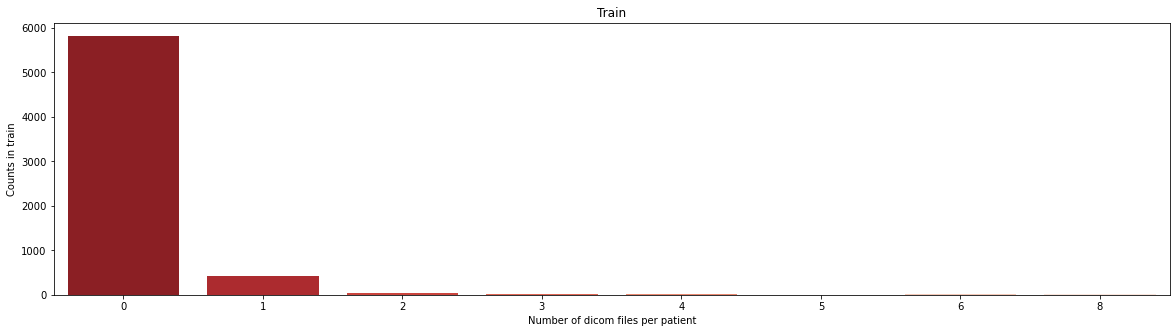

In [78]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(train.num_files, ax=ax, palette="Reds_r")
ax.set_xlabel("Number of dicom files per patient")
ax.set_ylabel("Counts in train");
ax.set_title("Train");

Ok, there are a few more cases with two dicom images and a few patients with more than 2! We should keep this in mind!

## Pixelspacing

## Number of rows and columns